In [1]:
import balltracking.balltrack as blt
import os, glob
import fitsio
from scipy.ndimage.filters import gaussian_filter 
from scipy.signal import convolve2d
from scipy.io import readsav
import numpy as np
import matplotlib
#matplotlib.use('tkagg')
import matplotlib.pyplot as plt
from matplotlib import rc
# Load FLCT
from pathlib import Path, PurePath
from IPython.display import display
import time
import pandas as pd


matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})
matplotlib.rcParams.update({'axes.labelsize': 12})

In [2]:
def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return np.array([vx, vy])


def smooth_vel(v, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm]) / fwhm**2
        vxs2 = convolve2d(v[0,...], box, mode='same')
        vys2 = convolve2d(v[1,...], box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(v[0,...], sigma=sigma, order=0)
        vys2 = gaussian_filter(v[1,...], sigma=sigma, order=0)
        
    vm = np.sqrt(vxs2**2 + vys2**2)
    return np.array([vxs2, vys2, vm])


# For FLCT
def read_vi(file, data_str):
    idl_dict = readsav(file)
    vi = idl_dict[data_str]
    return vi


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson

In [90]:
datadir = os.path.join(os.environ['DATA'], 'Ben/SteinSDO')
outputdir = os.path.join(datadir, 'comparisons')

u = 368000 / 60

fwhms = [7,11,15]
kernels = ['boxcar', 'gaussian']
kernel = 'boxcar'
dims = [263, 263]
# Select a subfield excluding edge effects
# Use same padding size as in Tremblay et al. 2018 used pad = 10
pad = max(fwhms)
fovs = [np.s_[pad:-pad:fwhm, pad:-pad:fwhm] for fwhm in fwhms]

nframes = range(30, 365, 5)
tranges = [[0, nt] for nt in range(30, 365, 5)]
nflows = len(tranges)
print("number of time-averaged flow maps: ", nflows)

number of time-averaged flow maps:  67


### Load Stein simulation data

In [91]:
# Load Stein data
svx_files = sorted(glob.glob(os.path.join(datadir,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(datadir,'SDO_vy*.fits')))
#vx, vy = load_vel_mean((svx_files, svy_files), tranges[0])
v_stein_l = [load_vel_mean((svx_files, svy_files), trange) for trange in tranges]
# smooth the Stein velocities 
v_stein_sm = [[smooth_vel(v, fwhm, kernel=kernel) for v in v_stein_l] for fwhm in fwhms]
npts_ = [v_stein_sm[f][0][0][fov].size for f, fov in enumerate(fovs)]

### Balltracking data

In [219]:
dfs1 = []
dfs2 = []

for i, fwhm_i in enumerate(fwhms):
    fov = fovs[i]
    # Load Balltrack velocities (processed with balltracking_scripts/generic_balltrack.py)
    bvs = [np.array([np.load(os.path.join(datadir, 'balltrack/vxy_{:s}_fwhm_{:d}_avg_{:d}.npz'.format(kernel, fwhm_i, trange[1])))[var] for var in ['vx', 'vy']]) for trange in tranges]
    bvsm = [np.sqrt(bvs[j][0][:]**2 + bvs[j][1][:]**2) for j in range(nflows)]
    
    # Fit Balltracking to Stein simulation
    bps, brs, _, _, _ = zip(*[np.polyfit(bvs[j][0][fov].ravel()*u, v_stein_sm[i][j][0][fov].ravel(), 1, full=True) for j in range(nflows)])
    brs = [np.sqrt(br[0]/npts_[i]) for br in brs]
    print('Balltrack residuals from fit: ', brs[0])
    b_alphas, b_offsets = map(list, zip(*bps))
    # Calculate residuals RMSE
    error_field = [np.abs(v_stein_sm[i][j][0][fov] - bvs[j][0][fov]*u).ravel() for j in range(nflows)]
    RMSEs = [np.sqrt(np.mean(error_field[j]**2)) for j in range(nflows)]
    # print('RMSE Balltracking = ',  b_RMSEs[0])
    # Relative error (Mean Absolute Percentage Error: MAPE)
    APE_field = [np.abs((v_stein_sm[i][j][2][fov] - bvsm[j][fov]*u)/np.ma.masked_less_equal(v_stein_sm[i][j][2][fov], 10)).ravel()*100 for j in range(nflows)]
    df1 = pd.concat([pd.DataFrame({'vmag': v_stein_sm[i][j][2][fov].ravel(), 'error':error_field[j], 'APE': APE_field[j], 'nframes':nframes[j], 'FWHM':fwhm_i, 'kernel':kernel, 'Algorithm':'Balltracking'}) for j in range(nflows)])
    
    bMAPE = [np.mean(APE_field[j]) for j in range(nflows)]
    # Correlations between Balltracking and simulation
    bcorrs = [calc_c_pearson(v_stein_sm[i][j][0], bvs[j][0], v_stein_sm[i][j][1], bvs[j][1], fov=fov) for j in range(len(tranges))]
    df2 = pd.DataFrame({'nframes':nframes, 'slope':b_alphas, 'RMSE':RMSEs, 'MAPE':bMAPE, 'correlation':bcorrs, 'FWHM':fwhm_i, 'kernel':kernel, 'Algorithm':'Balltracking'})
    
    dfs1.append(df1)
    dfs2.append(df2)

bdf1 = pd.concat(dfs1)
bdf2 = pd.concat(dfs2)
display(bdf1.head())
display(bdf2.head())

Balltrack residuals from fit:  271.7009522157599
Balltrack residuals from fit:  167.41413412252535
Balltrack residuals from fit:  120.39669989614572


,vmag,error,APE,nframes,FWHM,kernel,Algorithm
0,1263.138768,18.067682,14.723627,30,7,boxcar,Balltracking
1,653.045884,90.565668,0.795946,30,7,boxcar,Balltracking
2,289.600865,312.404331,86.996161,30,7,boxcar,Balltracking
3,566.230533,73.462099,12.656331,30,7,boxcar,Balltracking
4,990.517420,62.559900,4.955712,30,7,boxcar,Balltracking


,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
0,30,0.994161,272.204687,39.810414,0.895366,7,boxcar,Balltracking
1,35,1.004012,256.651434,38.982647,0.905166,7,boxcar,Balltracking
2,40,1.011541,240.212784,34.614980,0.915262,7,boxcar,Balltracking
3,45,1.023949,228.692444,31.008871,0.922140,7,boxcar,Balltracking
4,50,1.030356,216.391396,31.267158,0.928940,7,boxcar,Balltracking


### FLCT data

In [93]:
# Load fits files
datadir_flct = os.path.expanduser('~/Data/Ben/SteinSDO/FLCT_Raphael/output_FLCT_sigma4')
fvx_files = sorted((glob.glob(os.path.join(datadir_flct, 'FLCT_vx*.fits'))))
fvy_files = sorted((glob.glob(os.path.join(datadir_flct, 'FLCT_vy*.fits'))))

In [94]:
# Average over time
fvs = [load_vel_mean((fvx_files, fvy_files), trange) for trange in tranges]

In [220]:
dfs1 = []
dfs2 = []

for i, fwhm_i in enumerate(fwhms):
    if fwhm_i == 7:
        fvs2 = [np.array([fv[0], fv[1], np.sqrt(fv[0][:]**2 + fv[1][:]**2)]) for fv in fvs]
    else:
        # Smooth Stein velocities
        fvs2 = [smooth_vel(fv, fwhm_i, kernel=kernel) for fv in fvs]
    
    fov = fovs[i]
    # Fit FLCT to Stein simulation
    fps, frs, _, _, _ = zip(*[np.polyfit(fvs2[j][0][fov].ravel()*u, v_stein_sm[i][j][0][fov].ravel(), 1, full=True) for j in range(nflows)])
    frs = [np.sqrt(fr[0]/npts_[i]) for fr in frs]
    print('FLCT residuals from fit: ', frs[0])
    f_alphas, f_offsets = map(list, zip(*fps))
    # Calculate residuals RMSE
    error_field = [np.abs(v_stein_sm[i][j][0][fov] - fvs2[j][0][fov]*u).ravel() for j in range(nflows)]
    RMSE_uncal = [np.sqrt(np.mean(error_field[j]**2)) for j in range(nflows)]
    # print('RMSE FLCT (uncalibrated) = ',  fRMSE_uncals[0])
    # Relative error (Mean Absolute Percentage Error: MAPE)
    APE_field = [np.abs((v_stein_sm[i][j][2][fov] - fvs2[j][2][fov]*u)/np.ma.masked_less_equal(v_stein_sm[i][j][2][fov], 10)).ravel()*100 for j in range(nflows)]
    df1 = pd.concat([pd.DataFrame({'vmag': v_stein_sm[i][j][2][fov].ravel(), 'error':error_field[j], 'APE': APE_field[j], 'nframes':nframes[j], 'FWHM':fwhm_i, 'kernel':kernel, 'Algorithm':'FLCT'}) for j in range(nflows)])  
    
    fMAPE = [np.mean(APE_field[j]) for j in range(nflows)]
    # Correlations between FLCT and simulation
    fcorrs = [calc_c_pearson(v_stein_sm[i][j][0], fvs2[j][0], v_stein_sm[i][j][1], fvs2[j][1], fov=fov) for j in range(nflows)]
    df2 = pd.DataFrame({'nframes':nframes, 'slope':f_alphas, 'RMSE':RMSE_uncal, 'MAPE':fMAPE, 'correlation':fcorrs, 'FWHM':fwhm_i, 'kernel':kernel, 'Algorithm':'FLCT'})
    dfs1.append(df1)
    dfs2.append(df2)
    
fdf1 = pd.concat(dfs1)
fdf2 = pd.concat(dfs2)
display(fdf1.head())
display(fdf2.head())

FLCT residuals from fit:  290.69401009334155
FLCT residuals from fit:  177.6300902710669
FLCT residuals from fit:  126.30100978193812


,vmag,error,APE,nframes,FWHM,kernel,Algorithm
0,1263.138768,84.197786,19.648502,30,7,boxcar,FLCT
1,653.045884,145.458094,27.454612,30,7,boxcar,FLCT
2,289.600865,289.355189,6.662853,30,7,boxcar,FLCT
3,566.230533,362.215219,64.273254,30,7,boxcar,FLCT
4,990.517420,250.591429,25.981623,30,7,boxcar,FLCT


,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
0,30,1.199179,306.231078,42.342534,0.883222,7,boxcar,FLCT
1,35,1.229822,287.959371,40.634160,0.898514,7,boxcar,FLCT
2,40,1.256576,273.699264,38.311047,0.910023,7,boxcar,FLCT
3,45,1.274100,264.455165,36.048485,0.916819,7,boxcar,FLCT
4,50,1.287402,255.281573,35.807449,0.922960,7,boxcar,FLCT


In [221]:
df1 = pd.concat([bdf1, fdf1]).reset_index()
df2 = pd.concat([bdf2, fdf2]).reset_index()

In [222]:
df2.query("Algorithm == 'FLCT' & FWHM == 15").head()

,index,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
335,0,30,1.288291,157.243505,35.104416,0.951687,15,boxcar,FLCT
336,1,35,1.306828,151.368134,32.383203,0.958069,15,boxcar,FLCT
337,2,40,1.331990,149.235730,31.634640,0.962598,15,boxcar,FLCT
338,3,45,1.348828,148.509171,32.375785,0.964175,15,boxcar,FLCT
339,4,50,1.348549,148.639684,33.241227,0.965511,15,boxcar,FLCT


In [223]:
df2.query("Algorithm == 'Balltracking' & FWHM == 15").head()

,index,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
134,0,30,0.973879,122.012264,27.789749,0.952576,15,boxcar,Balltracking
135,1,35,0.971125,117.438799,25.264620,0.957189,15,boxcar,Balltracking
136,2,40,0.989413,108.840533,21.493694,0.962171,15,boxcar,Balltracking
137,3,45,1.005849,104.198325,20.669467,0.965203,15,boxcar,Balltracking
138,4,50,1.007878,100.176293,21.474383,0.969160,15,boxcar,Balltracking


In [224]:
import seaborn as sns
sns.set(font_scale=2)
sns.set_style('whitegrid')
%matplotlib inline

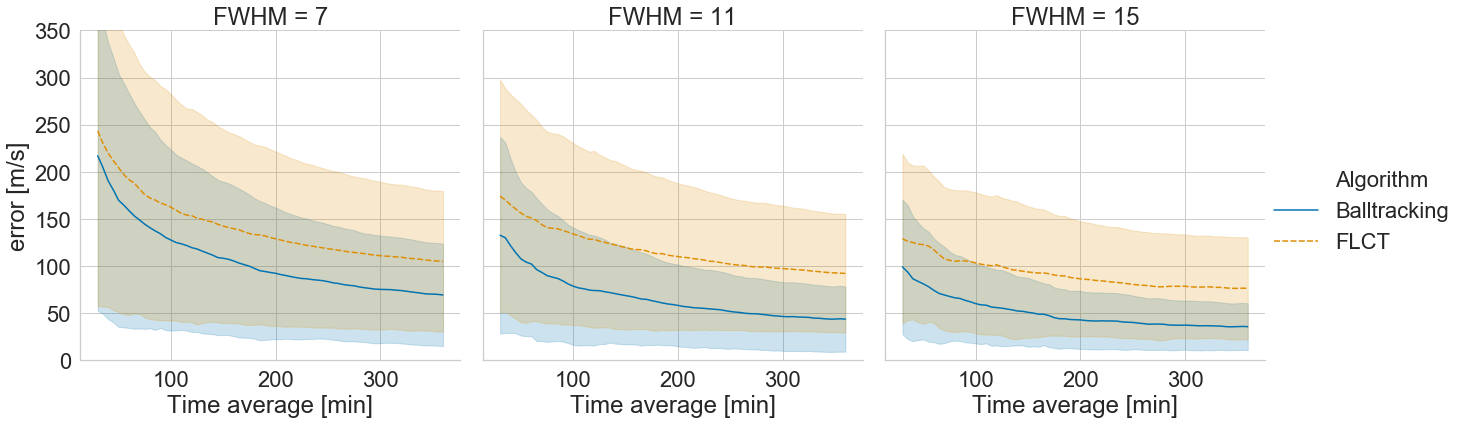

In [225]:
g1 = sns.relplot(data=df1, x='nframes', y='error',style='Algorithm', hue='Algorithm', col='FWHM', kind='line', ci='sd', legend='full', 
            palette='colorblind', height=6)
g1.set(xlabel='Time average [min]', ylabel='error [m/s]', ylim=[0, 350])
plt.savefig(PurePath(outputdir, 'error.png'))

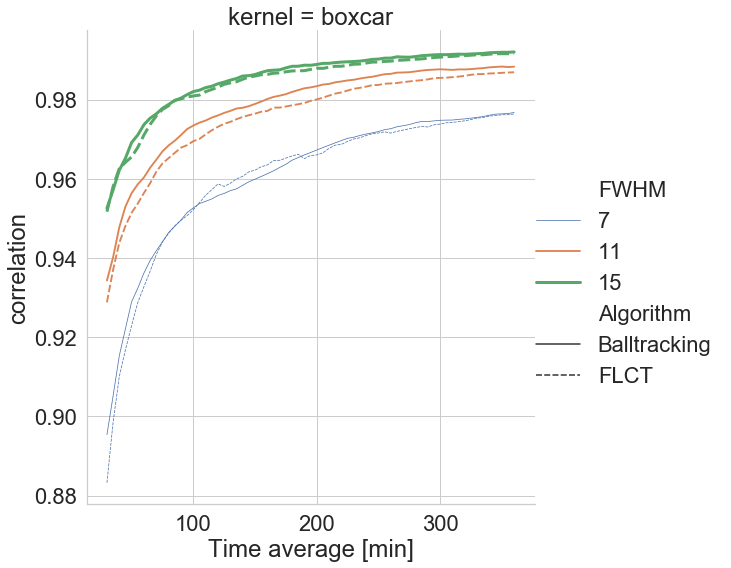

In [226]:
g1 = sns.relplot(data=df2, x='nframes', y='correlation', style='Algorithm', col='kernel', hue='FWHM', size='FWHM', kind='line', legend='full', 
            palette='deep', height=8)
g1.set(xlabel='Time average [min]')
plt.savefig(PurePath(outputdir, 'correlation.png'))

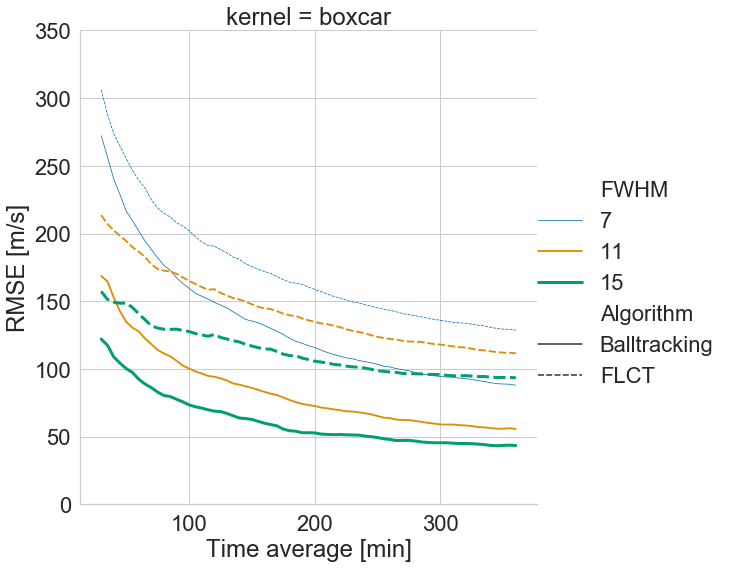

In [227]:
g2 = sns.relplot(data=df2, x='nframes', y='RMSE', style='Algorithm', col='kernel', hue='FWHM', size='FWHM', kind='line', legend='full', 
            palette='colorblind', height=8)
g2.set(xlabel='Time average [min]', ylabel='RMSE [m/s]', ylim=[0, 350])
plt.savefig(PurePath(outputdir, 'rmse.png'))


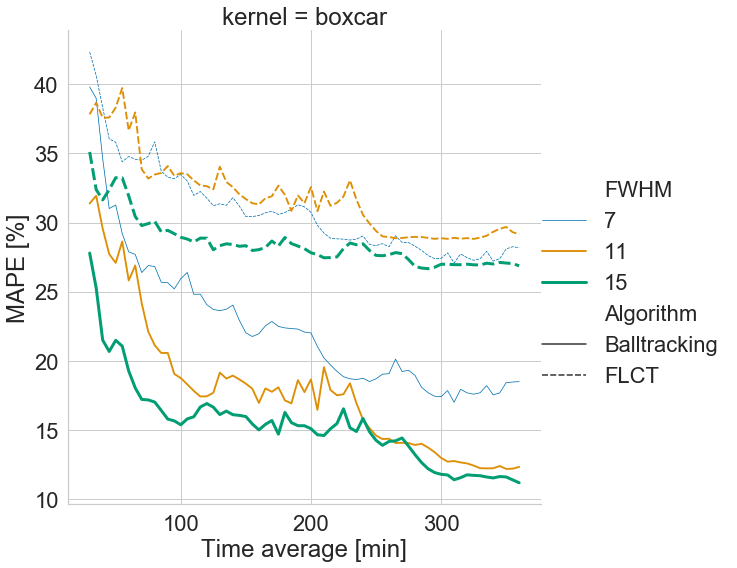

In [228]:
g3 = sns.relplot(data=df2, x='nframes', y='MAPE', style='Algorithm', col='kernel', hue='FWHM', size='FWHM', kind='line', legend='full', 
            palette='colorblind', height=8)
g3.set(xlabel='Time average [min]', ylabel='MAPE [%]')
plt.savefig(PurePath(outputdir, 'mape.png'))

In [110]:
df2.head()

,nframes,slope,RMSE,MAPE,correlation,FWHM,kernel,Algorithm
0,30,0.994161,272.204687,39.810414,0.895366,7,boxcar,Balltracking
1,35,1.004012,256.651434,38.982647,0.905166,7,boxcar,Balltracking
2,40,1.011541,240.212784,34.614980,0.915262,7,boxcar,Balltracking
3,45,1.023949,228.692444,32.488067,0.922140,7,boxcar,Balltracking
4,50,1.030356,216.391396,31.267158,0.928940,7,boxcar,Balltracking


In [152]:
df2['MAPE'].max(), df2['MAPE'].idxmax()

(46.022592116519135, 300)

In [153]:
df2.loc[df2['MAPE'].idxmax()]

index                32
nframes             190
slope           1.37377
RMSE            137.228
MAPE            46.0226
correlation    0.979133
FWHM                 11
kernel           boxcar
Algorithm          FLCT
Name: 300, dtype: object

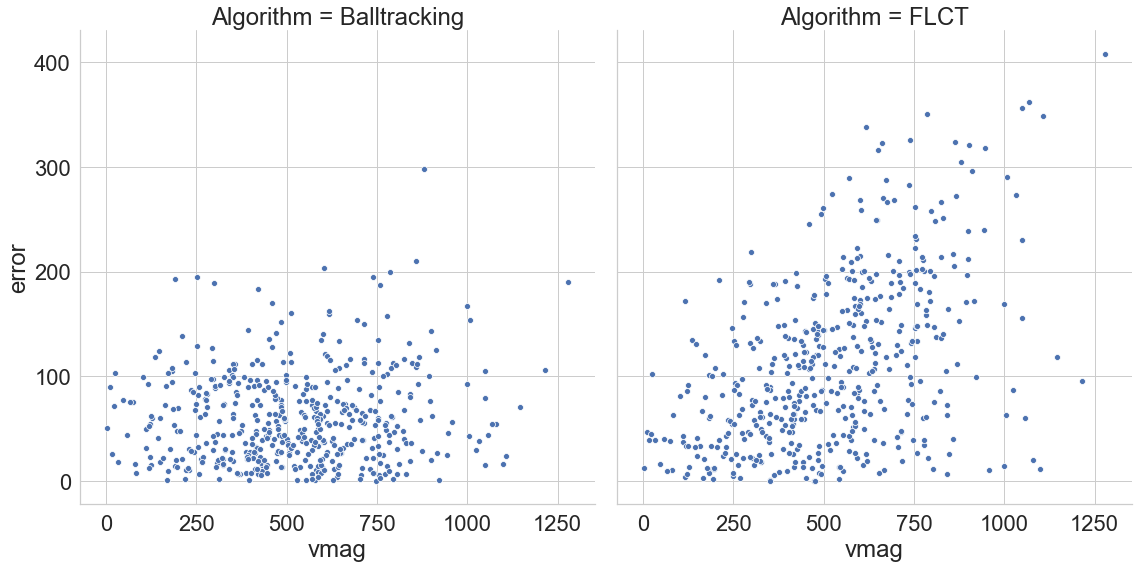

In [196]:
g = sns.relplot(data=df1.query("nframes == 190 & FWHM == 11"), x='vmag', y='error', col='Algorithm', height=8, palette='colorblind')



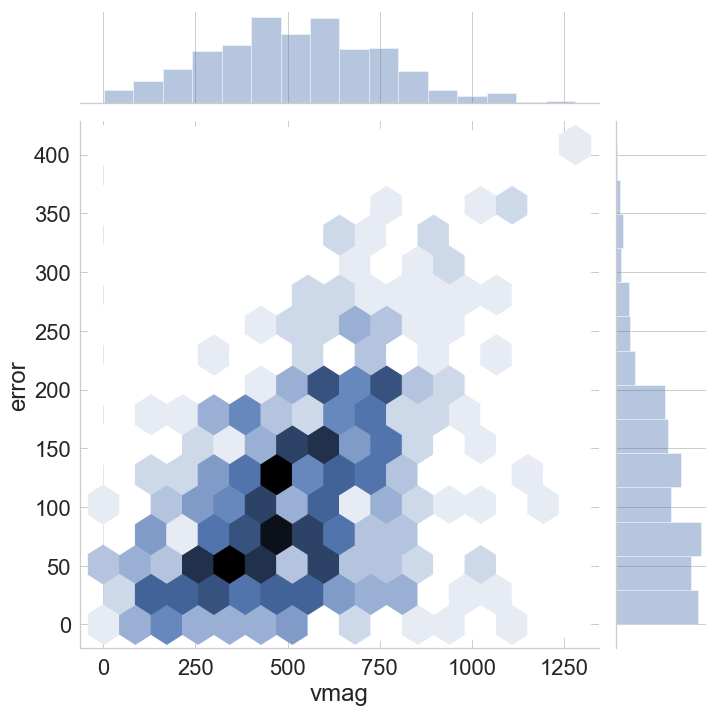

In [201]:
g = sns.jointplot(data=df1.query("nframes == 190 & FWHM == 11 & Algorithm == 'FLCT'"), 
                  x='vmag', y='error', height=10, kind='hex')


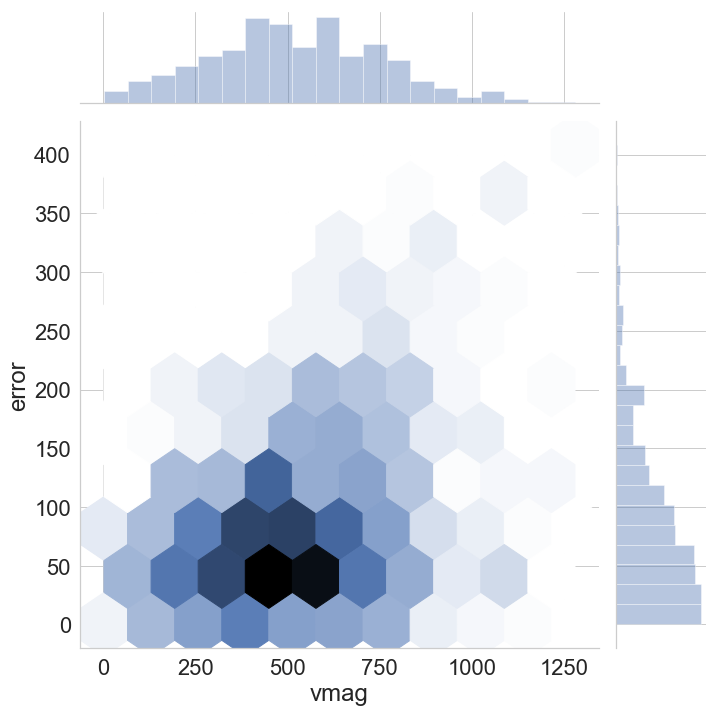

In [232]:
sns.catplot(x="FWHM", y="APE", kind="box", data=df1.query("nframes == 190 & FWHM == 11 & Algorithm == 'FLCT'");

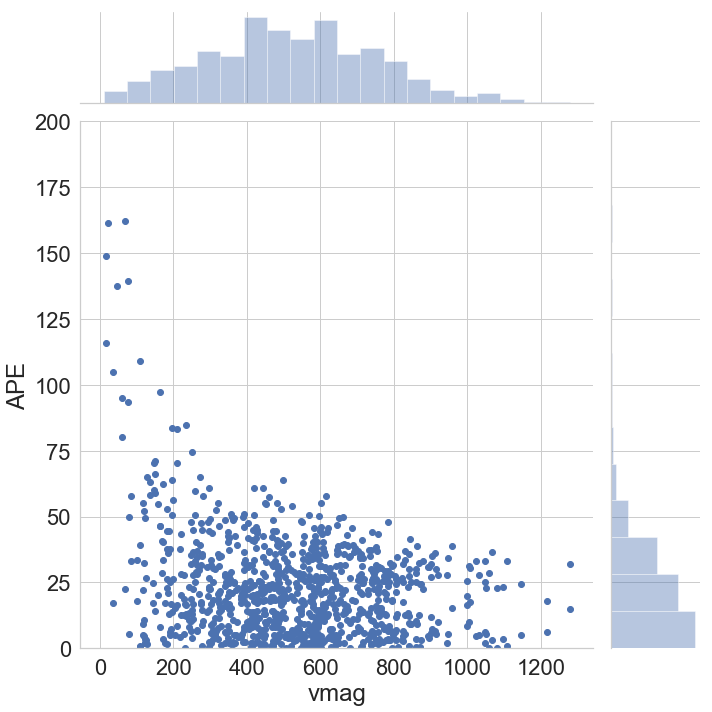

In [243]:
g = sns.jointplot(data=df1.query("nframes == 190 & FWHM == 11"), 
                  x='vmag', y='APE', height=10, kind='scatter', ylim=[0, 200])


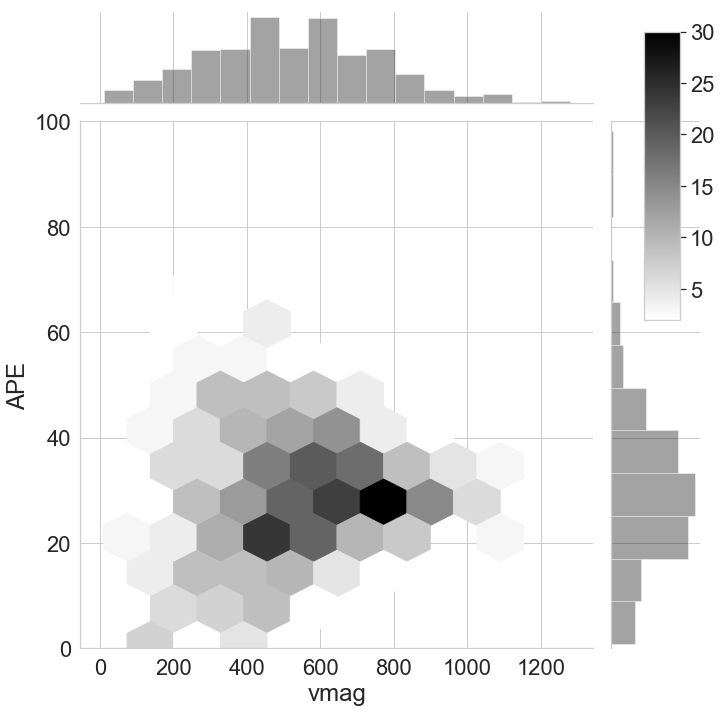

In [278]:
g = sns.jointplot(data=df1.query("nframes == 190 & FWHM == 11 & Algorithm == 'FLCT'"), 
                  x='vmag', y='APE', height=10, kind='hex', ylim=[0, 100], color='k', 
                  joint_kws={'gridsize':(10, 30), 'mincnt':2})

cbar_ax = g.fig.add_axes([.9, .55, .05, .4])
plt.colorbar(cax=cbar_ax)

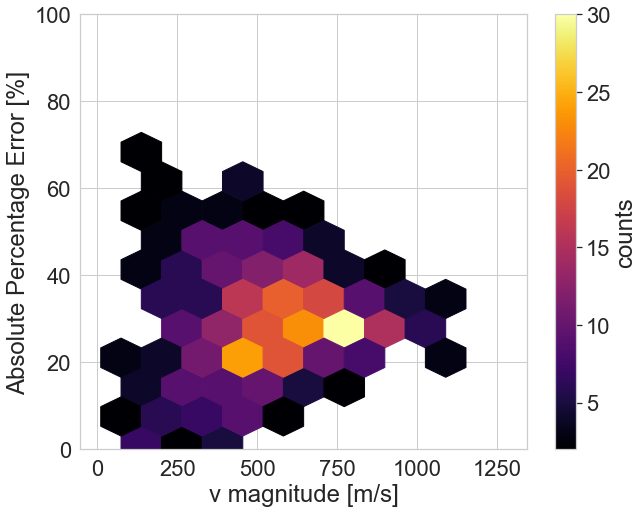

In [286]:
data=df1.query("nframes == 190 & FWHM == 11 & Algorithm == 'FLCT'")
fig, ax = plt.subplots(figsize=(10,8))
hb = ax.hexbin(data['vmag'], data['APE'], gridsize=(10,30), cmap='inferno', mincnt=2)
ax.set(ylim=(0,100), xlabel='v magnitude [m/s]', ylabel='Absolute Percentage Error [%]')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

In [107]:
mape_argmax = df1.query("nframes == 185 & FWHM == 11 & Algorithm == 'Balltracking'")['MAPE'].idxmax()

In [108]:
df1.iloc[mape_argmax]

vmag              328.387
error             65.9418
MAPE              86.1004
nframes                30
FWHM                    7
kernel             boxcar
Algorithm    Balltracking
Name: 25, dtype: object

### Plot spatially-averaged scaling error as a function of time average

### Drift test